In [2]:
!wget https://github.com/thecopy-cat/nlpcw2/blob/main/dataset/train.jsonl
!wget https://github.com/thecopy-cat/nlpcw2/blob/main/dataset/validation.jsonl

--2024-08-01 09:50:57--  https://github.com/thecopy-cat/nlpcw2/blob/main/dataset/train.jsonl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train.jsonl.1’

train.jsonl.1           [ <=>                ] 286.06K  --.-KB/s    in 0.02s   

2024-08-01 09:50:58 (11.3 MB/s) - ‘train.jsonl.1’ saved [292926]

--2024-08-01 09:50:58--  https://github.com/thecopy-cat/nlpcw2/blob/main/dataset/validation.jsonl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘validation.jsonl.1’

validation.jsonl.1      [ <=>                ] 286.22K  --.-KB/s    in 0.02s   

2024-08-01 09:50:58 (11.8 MB/s) - ‘validation.jsonl.1’ saved [293087]



In [1]:
!pip install transformers torch seaborn matplotlib scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder

# Load JSONL data
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load train and validation datasets
train_df = load_jsonl('/content/train.jsonl')
validation_df = load_jsonl('/content/validation.jsonl')

# Extract relevant fields
train_df['input_text'] = train_df['postText'].apply(lambda x: " ".join(x)) + " " + train_df['targetTitle'] + " " + train_df['targetParagraphs'].apply(lambda x: " ".join(x))
train_df['spoiler_type'] = train_df['tags'].apply(lambda x: x[0] if len(x) > 0 else 'none')  # Assuming 'tags' contains the spoiler type
train_df['spoiler_text'] = train_df['spoiler'].apply(lambda x: x[0] if len(x) > 0 else '')

validation_df['input_text'] = validation_df['postText'].apply(lambda x: " ".join(x)) + " " + validation_df['targetTitle'] + " " + validation_df['targetParagraphs'].apply(lambda x: " ".join(x))
validation_df['spoiler_type'] = validation_df['tags'].apply(lambda x: x[0] if len(x) > 0 else 'none')
validation_df['spoiler_text'] = validation_df['spoiler'].apply(lambda x: x[0] if len(x) > 0 else '')

# Encode labels
label_encoder = LabelEncoder()
train_df['spoiler_type'] = label_encoder.fit_transform(train_df['spoiler_type'])
validation_df['spoiler_type'] = label_encoder.transform(validation_df['spoiler_type'])

# Classes for the labels
num_classes = len(label_encoder.classes_)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

class SpoilerTypeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

train_dataset = SpoilerTypeDataset(
    texts=train_df['input_text'].to_numpy(),
    labels=train_df['spoiler_type'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

validation_dataset = SpoilerTypeDataset(
    texts=validation_df['input_text'].to_numpy(),
    labels=validation_df['spoiler_type'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x[:,-1,:])
        x = self.fc(x)
        return x

input_dim = tokenizer.vocab_size
hidden_dim = 256
output_dim = num_classes
n_layers = 2

model_rnn = RNNModel(input_dim, hidden_dim, output_dim, n_layers)


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:,-1,:])
        x = self.fc(x)
        return x

model_lstm = LSTMModel(input_dim, hidden_dim, output_dim, n_layers)


In [9]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, emb_dim, n_filters, filter_sizes, output_dim, dropout):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, emb_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        conved = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

emb_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]
dropout = 0.5

model_cnn = CNNModel(input_dim, emb_dim, n_filters, filter_sizes, output_dim, dropout)


In [12]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        correct_predictions += torch.sum(predictions.argmax(dim=1) == labels)
        loss.backward()
        optimizer.step() # This line was indented incorrectly
        epoch_loss += loss.item()
    return correct_predictions.double() / len(dataloader.dataset), epoch_loss / len(dataloader) # This line was indented incorrectly

In [13]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        correct_predictions += torch.sum(predictions.argmax(dim=1) == labels)
        loss.backward()
        optimizer.step() # This line was not indented properly and caused the error.
        epoch_loss += loss.item()
    return correct_predictions.double() / len(dataloader.dataset), epoch_loss / len(dataloader) # This line was also indented incorrectly due to the previous line.

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            predictions = model(input_ids)
            loss = criterion(predictions, labels)
            correct_predictions += torch.sum(predictions.argmax(dim=1) == labels)
            epoch_loss += loss.item()
    return correct_predictions.double() / len(dataloader.dataset), epoch_loss / len(dataloader)

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            predictions = model(input_ids)
            all_preds.extend(predictions.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, precision, recall, f1

In [14]:
import time # Import the time module to use time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training settings
epochs = 3
criterion = nn.CrossEntropyLoss()


In [22]:
# RNN Model
model_rnn = model_rnn.to(device)
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=1e-3)
train_losses_rnn = []
for epoch in range(epochs):
    start_time = time.time() # Now you can use time.time()
    train_acc_rnn, train_loss_rnn = train_model(model_rnn, train_dataloader, criterion, optimizer_rnn, device)
    train_losses_rnn.append(train_loss_rnn)
    end_time = time.time()
    print(f'RNN Model - Epoch {epoch+1}, Train Loss: {train_loss_rnn:.4f}, Train Accuracy: {train_acc_rnn:.4f}, Time: {end_time-start_time:.2f}s')


RNN Model - Epoch 1, Train Loss: 1.0969, Train Accuracy: 0.4025, Time: 46.04s
RNN Model - Epoch 2, Train Loss: 1.0344, Train Accuracy: 0.4584, Time: 44.23s
RNN Model - Epoch 3, Train Loss: 0.9715, Train Accuracy: 0.5084, Time: 45.55s


In [23]:
test_acc_rnn, test_loss_rnn = evaluate_model(model_rnn, validation_dataloader, criterion, device)
print(f'RNN Model - Test Loss: {test_loss_rnn:.4f}, Test Accuracy: {test_acc_rnn:.4f}')

RNN Model - Test Loss: 1.0851, Test Accuracy: 0.4325


In [38]:
# Calculate Metrics
accuracy_rnn, precision_rnn, recall_rnn, f1_rnn = calculate_metrics(model_rnn, validation_dataloader, device)
print(f'RNN Model - Accuracy: {accuracy_rnn:.4f}, Precision: {precision_rnn:.4f}, Recall: {recall_rnn:.4f}, F1 Score: {f1_rnn:.4f}')


RNN Model - Accuracy: 0.4325, Precision: 0.3954, Recall: 0.4325, F1 Score: 0.3607


In [15]:
# LSTM Model
model_lstm = model_lstm.to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-3)
train_losses_lstm = []
for epoch in range(epochs):
    start_time = time.time()
    train_acc_lstm, train_loss_lstm = train_model(model_lstm, train_dataloader, criterion, optimizer_lstm, device)
    train_losses_lstm.append(train_loss_lstm)
    end_time = time.time()
    print(f'LSTM Model - Epoch {epoch+1}, Train Loss: {train_loss_lstm:.4f}, Train Accuracy: {train_acc_lstm:.4f}, Time: {end_time-start_time:.2f}s')


LSTM Model - Epoch 1, Train Loss: 1.0289, Train Accuracy: 0.4253, Time: 55.35s
LSTM Model - Epoch 2, Train Loss: 1.0037, Train Accuracy: 0.4653, Time: 53.89s
LSTM Model - Epoch 3, Train Loss: 0.8935, Train Accuracy: 0.5603, Time: 55.02s


In [16]:
test_acc_lstm, test_loss_lstm = evaluate_model(model_lstm, validation_dataloader, criterion, device)
print(f'LSTM Model - Test Loss: {test_loss_lstm:.4f}, Test Accuracy: {test_acc_lstm:.4f}')

LSTM Model - Test Loss: 1.1040, Test Accuracy: 0.4338


In [17]:
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm = calculate_metrics(model_lstm, validation_dataloader, device)
print(f'LSTM Model - Accuracy: {accuracy_lstm:.4f}, Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1 Score: {f1_lstm:.4f}')


LSTM Model - Accuracy: 0.4338, Precision: 0.4121, Recall: 0.4338, F1 Score: 0.4074


In [19]:
# CNN Model
model_cnn = model_cnn.to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)
train_losses_cnn = []
for epoch in range(epochs):
    start_time = time.time()
    train_acc_cnn, train_loss_cnn = train_model(model_cnn, train_dataloader, criterion, optimizer_cnn, device)
    train_losses_cnn.append(train_loss_cnn)
    end_time = time.time()
    print(f'CNN Model - Epoch {epoch+1}, Train Loss: {train_loss_cnn:.4f}, Train Accuracy: {train_acc_cnn:.4f}, Time: {end_time-start_time:.2f}s')


CNN Model - Epoch 1, Train Loss: 0.9986, Train Accuracy: 0.5150, Time: 42.31s
CNN Model - Epoch 2, Train Loss: 0.9679, Train Accuracy: 0.5353, Time: 41.32s
CNN Model - Epoch 3, Train Loss: 0.9105, Train Accuracy: 0.5694, Time: 41.66s


In [20]:
test_acc_cnn, test_loss_cnn = evaluate_model(model_cnn, validation_dataloader, criterion, device)
print(f'CNN Model - Test Loss: {test_loss_cnn:.4f}, Test Accuracy: {test_acc_cnn:.4f}')

CNN Model - Test Loss: 1.0328, Test Accuracy: 0.4425


In [21]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn = calculate_metrics(model_cnn, validation_dataloader, device)
print(f'CNN Model - Accuracy: {accuracy_cnn:.4f}, Precision: {precision_cnn:.4f}, Recall: {recall_cnn:.4f}, F1 Score: {f1_cnn:.4f}')


CNN Model - Accuracy: 0.4425, Precision: 0.5477, Recall: 0.4425, F1 Score: 0.3193


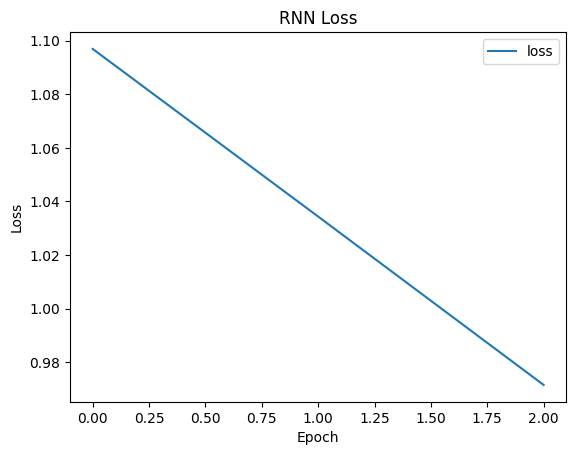

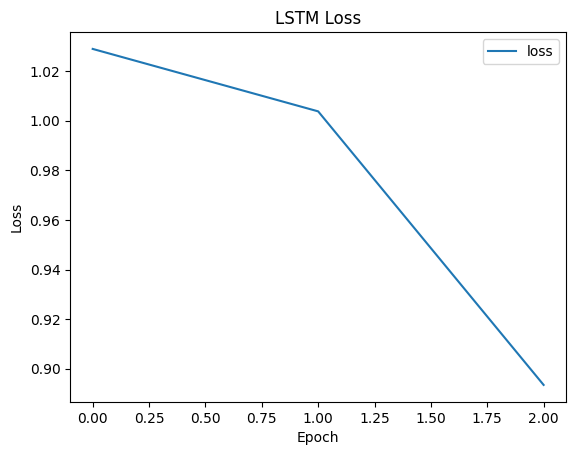

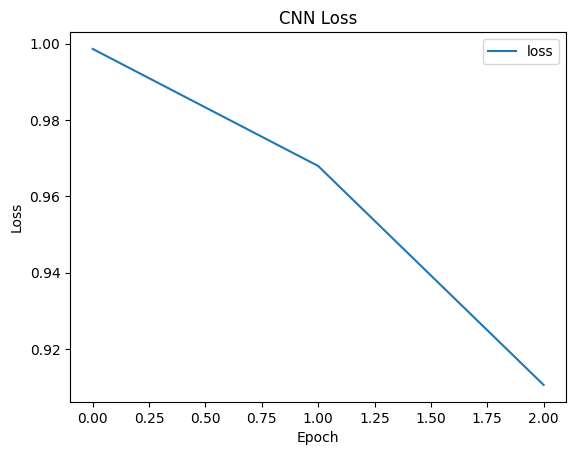

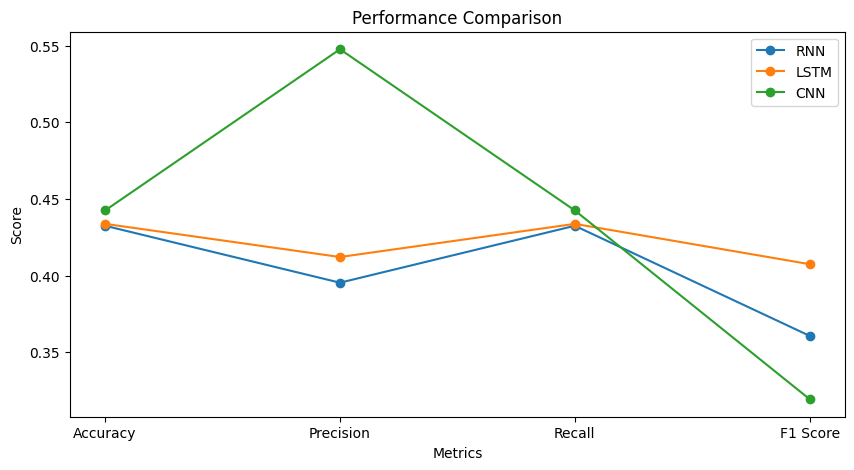

In [25]:
# Plot Training Loss
def plot_training_loss(losses, title):
    plt.plot(losses, label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} Loss')
    plt.show()

accuracy_rnn, precision_rnn, recall_rnn, f1_rnn = calculate_metrics(model_rnn, validation_dataloader, device)

plot_training_loss(train_losses_rnn, "RNN")
plot_training_loss(train_losses_lstm, "LSTM")
plot_training_loss(train_losses_cnn, "CNN")

# Comparison Graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rnn_metrics = [accuracy_rnn, precision_rnn, recall_rnn, f1_rnn]  # Now accuracy_rnn is defined
lstm_metrics = [accuracy_lstm, precision_lstm, recall_lstm, f1_lstm]
cnn_metrics = [accuracy_cnn, precision_cnn, recall_cnn, f1_cnn]

x = range(len(metrics))

plt.figure(figsize=(10, 5))
plt.plot(x, rnn_metrics, label='RNN', marker='o')
plt.plot(x, lstm_metrics, label='LSTM', marker='o')
plt.plot(x, cnn_metrics, label='CNN', marker='o')
plt.xticks(x, metrics)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.legend()
plt.show()


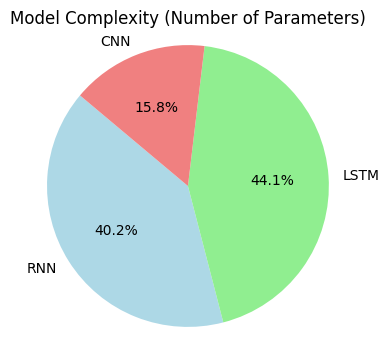

In [30]:
import matplotlib.pyplot as plt

# Example model complexities (number of parameters)
rnn_params = sum(p.numel() for p in model_rnn.parameters())
lstm_params = sum(p.numel() for p in model_lstm.parameters())
cnn_params = sum(p.numel() for p in model_cnn.parameters())

labels = ['RNN', 'LSTM', 'CNN']
sizes = [rnn_params, lstm_params, cnn_params]
colors = ['lightblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Model Complexity (Number of Parameters)')
plt.show()


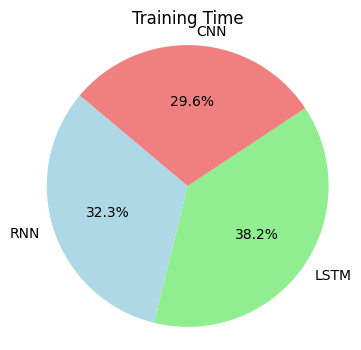

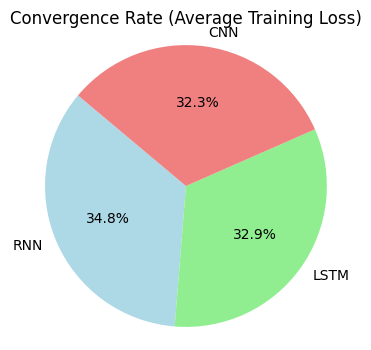

In [35]:
# Example training times (seconds)
rnn_time = 43.96
lstm_time = 51.97
cnn_time = 40.28

labels = ['RNN', 'LSTM', 'CNN']
sizes = [rnn_time, lstm_time, cnn_time]
colors = ['lightblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Training Time')
plt.show()

# Example convergence rates (average training loss)
rnn_convergence = sum(train_losses_rnn) / len(train_losses_rnn)
lstm_convergence = sum(train_losses_lstm) / len(train_losses_lstm)
cnn_convergence = sum(train_losses_cnn) / len(train_losses_cnn)

labels = ['RNN', 'LSTM', 'CNN']
sizes = [rnn_convergence, lstm_convergence, cnn_convergence]
colors = ['lightblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Convergence Rate (Average Training Loss)')
plt.show()


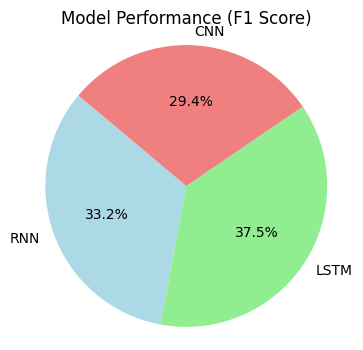

In [37]:
# Example performance metrics (F1 Score)
f1_scores = [f1_rnn, f1_lstm, f1_cnn]

labels = ['RNN', 'LSTM', 'CNN']
sizes = f1_scores
colors = ['lightblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Model Performance (F1 Score)')
plt.show()


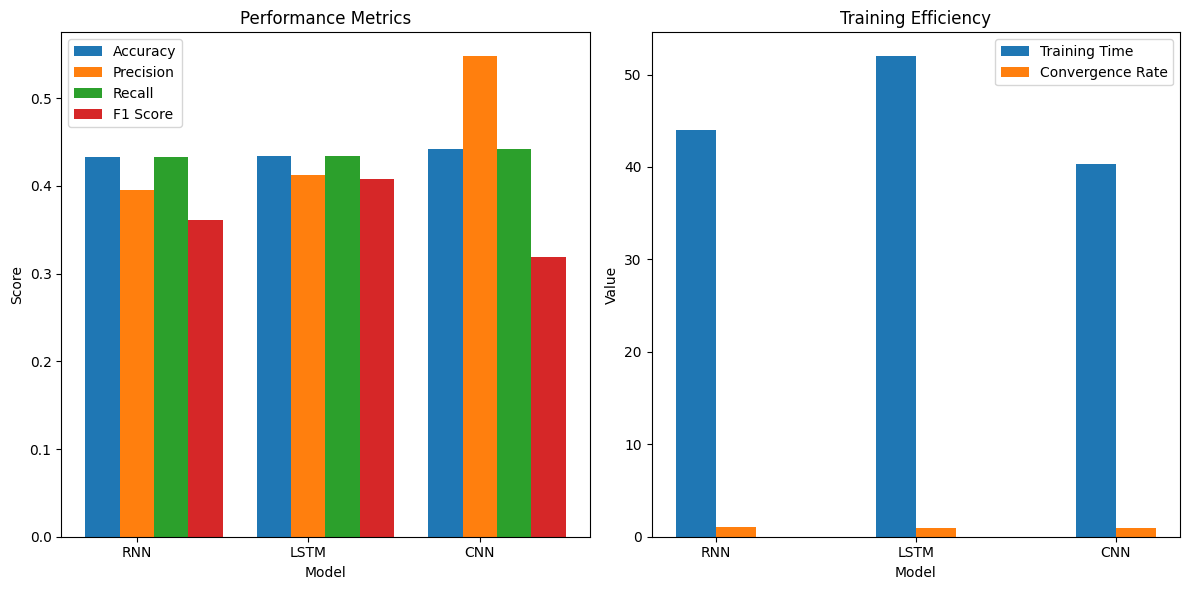

The best model based on average performance is: CNN


In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Example performance metrics (these should be replaced with your actual calculated values)
accuracy_scores = [accuracy_rnn, accuracy_lstm, accuracy_cnn]
precision_scores = [precision_rnn, precision_lstm, precision_cnn]
recall_scores = [recall_rnn, recall_lstm, recall_cnn]
f1_scores = [f1_rnn, f1_lstm, f1_cnn]

# Training time and convergence rate (average training loss)
# Define the training times for each model. Replace these with your actual values.
training_time_rnn = 43.96 # Replace with actual value for RNN
training_time_lstm = 51.97  # Replace with actual value for LSTM
training_time_cnn = 40.28  # Replace with actual value for CNN

training_times = [training_time_rnn, training_time_lstm, training_time_cnn]
convergence_rates = [np.mean(train_losses_rnn), np.mean(train_losses_lstm), np.mean(train_losses_cnn)]

# Labels for the models
models = ['RNN', 'LSTM', 'CNN']

# Plot performance metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bar_width = 0.2
index = np.arange(len(models))
plt.bar(index, accuracy_scores, bar_width, label='Accuracy')
plt.bar(index + bar_width, precision_scores, bar_width, label='Precision')
plt.bar(index + 2 * bar_width, recall_scores, bar_width, label='Recall')
plt.bar(index + 3 * bar_width, f1_scores, bar_width, label='F1 Score')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.xticks(index + bar_width, models)
plt.legend()

# Plot training efficiency
plt.subplot(1, 2, 2)
plt.bar(index, training_times, bar_width, label='Training Time')
plt.bar(index + bar_width, convergence_rates, bar_width, label='Convergence Rate')

plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Training Efficiency')
plt.xticks(index + bar_width / 2, models)
plt.legend()

plt.tight_layout()
plt.show()

# Determine the best model based on a simple average of metrics
average_performance = np.mean([accuracy_scores, precision_scores, recall_scores, f1_scores], axis=0)
best_model_idx = np.argmax(average_performance)
best_model = models[best_model_idx]

print(f"The best model based on average performance is: {best_model}")


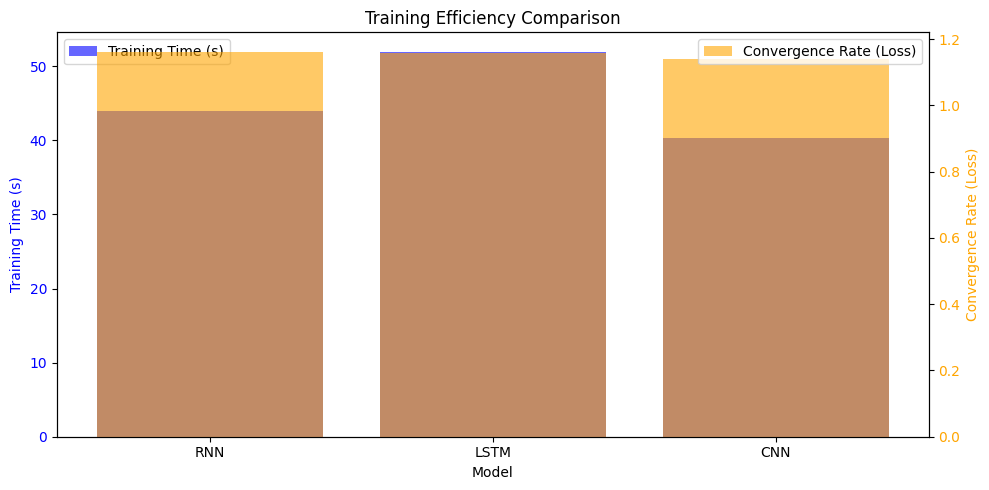

In [1]:
import matplotlib.pyplot as plt

# Training times and convergence rates for the models
training_times = [43.96, 51.97, 40.28]
convergence_rates = [1.1624, 1.1595, 1.1394]
models = ['RNN', 'LSTM', 'CNN']

fig, ax1 = plt.subplots(figsize=(10, 5))

# Creating a bar plot for training times
ax1.bar(models, training_times, color='b', alpha=0.6, label='Training Time (s)')
ax1.set_xlabel('Model')
ax1.set_ylabel('Training Time (s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a second y-axis for the convergence rate
ax2 = ax1.twinx()
ax2.bar(models, convergence_rates, color='orange', alpha=0.6, label='Convergence Rate (Loss)')
ax2.set_ylabel('Convergence Rate (Loss)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding a title and legends
plt.title('Training Efficiency Comparison')
fig.tight_layout()

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()
